In [26]:
from collections.abc import Iterable
import numpy as np
new_float_type = {
    # preserved types
    np.float32().dtype.char: np.float32,
    np.float64().dtype.char: np.float64,
    np.complex64().dtype.char: np.complex64,
    np.complex128().dtype.char: np.complex128,
    # altered types
    np.float16().dtype.char: np.float32,
    'g': np.float64,      # np.float128 ; doesn't exist on windows
    'G': np.complex128,   # np.complex256 ; doesn't exist on windows
}

def _supported_float_type(input_dtype, allow_complex=False):
    if isinstance(input_dtype, Iterable) and not isinstance(input_dtype, str):
        return np.result_type(*(_supported_float_type(d) for d in input_dtype))
    input_dtype = np.dtype(input_dtype)
    if not allow_complex and input_dtype.kind == 'c':
        raise ValueError("complex valued input is not supported")
    return new_float_type.get(input_dtype.char, np.float64)


In [27]:

from scipy.interpolate import RectBivariateSpline
from skimage import img_as_float
from skimage.filters import sobel
def active_contour(image, snake, alpha=0.015, beta=10,
                   w_line=0, w_edge=1, gamma=0.001,
                   max_px_move=1.0,
                   max_num_iter=2500, convergence=0.1,
                   *,
                   boundary_condition='periodic'):
    
    max_num_iter = int(max_num_iter)
    if max_num_iter <= 0:
        raise ValueError("max_num_iter should be >0.")
    convergence_order = 10
    valid_bcs = ['periodic', 'free', 'fixed', 'free-fixed',
                 'fixed-free', 'fixed-fixed', 'free-free']
    if boundary_condition not in valid_bcs:
        raise ValueError("Invalid boundary condition.\n" +
                         "Should be one of: "+", ".join(valid_bcs)+'.')

    img = img_as_float(image)
    float_dtype = _supported_float_type(image.dtype)
    img = img.astype(float_dtype, copy=False)

    RGB = img.ndim == 3

    # Find edges using sobel:
    if w_edge != 0:
        if RGB:
            edge = [sobel(img[:, :, 0]), sobel(img[:, :, 1]),
                    sobel(img[:, :, 2])]
        else:
            edge = [sobel(img)]
    else:
        edge = [0]

    # Superimpose intensity and edge images:
    if RGB:
        img = w_line*np.sum(img, axis=2) \
            + w_edge*sum(edge)
    else:
        img = w_line*img + w_edge*edge[0]

    # Interpolate for smoothness:
    intp = RectBivariateSpline(np.arange(img.shape[1]),
                               np.arange(img.shape[0]),
                               img.T, kx=2, ky=2, s=0)

    snake_xy = snake[:, ::-1]
    x = snake_xy[:, 0].astype(float_dtype)
    y = snake_xy[:, 1].astype(float_dtype)
    n = len(x)
    xsave = np.empty((convergence_order, n), dtype=float_dtype)
    ysave = np.empty((convergence_order, n), dtype=float_dtype)

    # Build snake shape matrix for Euler equation in double precision
    eye_n = np.eye(n, dtype=float)
    a = (np.roll(eye_n, -1, axis=0)
         + np.roll(eye_n, -1, axis=1)
         - 2 * eye_n)  # second order derivative, central difference
    b = (np.roll(eye_n, -2, axis=0)
         + np.roll(eye_n, -2, axis=1)
         - 4 * np.roll(eye_n, -1, axis=0)
         - 4 * np.roll(eye_n, -1, axis=1)
         + 6 * eye_n)  # fourth order derivative, central difference
    A = -alpha * a + beta * b

    # Impose boundary conditions different from periodic:
    sfixed = False
    if boundary_condition.startswith('fixed'):
        A[0, :] = 0
        A[1, :] = 0
        A[1, :3] = [1, -2, 1]
        sfixed = True
    efixed = False
    if boundary_condition.endswith('fixed'):
        A[-1, :] = 0
        A[-2, :] = 0
        A[-2, -3:] = [1, -2, 1]
        efixed = True
    sfree = False
    if boundary_condition.startswith('free'):
        A[0, :] = 0
        A[0, :3] = [1, -2, 1]
        A[1, :] = 0
        A[1, :4] = [-1, 3, -3, 1]
        sfree = True
    efree = False
    if boundary_condition.endswith('free'):
        A[-1, :] = 0
        A[-1, -3:] = [1, -2, 1]
        A[-2, :] = 0
        A[-2, -4:] = [-1, 3, -3, 1]
        efree = True

    # Only one inversion is needed for implicit spline energy minimization:
    inv = np.linalg.inv(A + gamma * eye_n)
    # can use float_dtype once we have computed the inverse in double precision
    inv = inv.astype(float_dtype, copy=False)

    # Explicit time stepping for image energy minimization:
    for i in range(max_num_iter):
        # RectBivariateSpline always returns float64, so call astype here
        fx = intp(x, y, dx=1, grid=False).astype(float_dtype, copy=False)
        fy = intp(x, y, dy=1, grid=False).astype(float_dtype, copy=False)

        if sfixed:
            fx[0] = 0
            fy[0] = 0
        if efixed:
            fx[-1] = 0
            fy[-1] = 0
        if sfree:
            fx[0] *= 2
            fy[0] *= 2
        if efree:
            fx[-1] *= 2
            fy[-1] *= 2
        xn = inv @ (gamma*x + fx)
        yn = inv @ (gamma*y + fy)

        # Movements are capped to max_px_move per iteration:
        dx = max_px_move * np.tanh(xn - x)
        dy = max_px_move * np.tanh(yn - y)
        if sfixed:
            dx[0] = 0
            dy[0] = 0
        if efixed:
            dx[-1] = 0
            dy[-1] = 0
        x += dx
        y += dy

        # Convergence criteria needs to compare to a number of previous
        # configurations since oscillations can occur.
        j = i % (convergence_order + 1)
        if j < convergence_order:
            xsave[j, :] = x
            ysave[j, :] = y
        else:
            dist = np.min(np.max(np.abs(xsave - x[None, :])
                                 + np.abs(ysave - y[None, :]), 1))
            if dist < convergence:
                break

    return np.stack([y, x], axis=1)

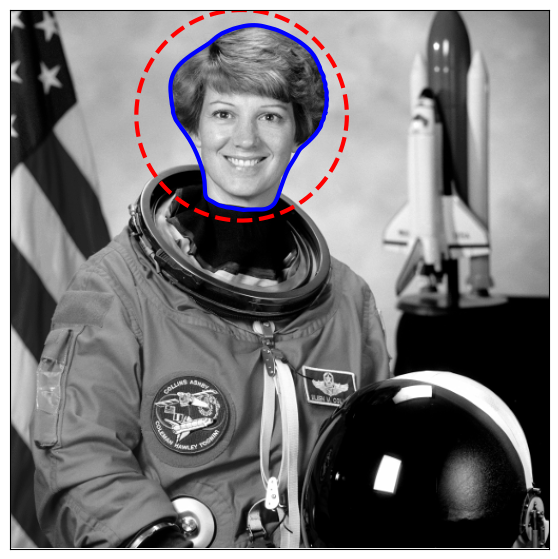

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
import numpy as np
from scipy.interpolate import RectBivariateSpline


# Load an image
img = data.astronaut()
img = rgb2gray(img)

# Initialize a circle around the astronaut's face
s = np.linspace(0, 2*np.pi, 400)
r = 100 + 100*np.sin(s)
c = 220 + 100*np.cos(s)
init = np.array([r, c]).T

# Apply active contour model with some parameters
snake = active_contour(gaussian(img, 3),
                       init)

# Plot the result
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])
plt.show()